An energy minimization procedure consists in adjusting the coordinates of the atoms that are too close from one another until one of the stopping criteria is reached. By default, LAMMPS uses the conjugate gradient (CG) algorithm. Here there are four stopping criteria:

    The change in energy between two iterations is less than 1.0e-4,

    The maximum force between two atoms in the system is lower than 1.0e-6,

    The maximum number of iterations is 1000,

    The maximum number of times the force and the energy have been evaluated is 10000.
    
NVT 
we preform a temperature adjustment using a canonical sampling thermostat.  the thermostat is similar to the empirical Berendsen thermostat in temp/berendsen, but chooses the actual scaling factor from a suitably chosen (gaussian) distribution rather than having it determined from the time constant directly.

Unlike the fix nvt command which performs Nose/Hoover thermostatting AND time integration, these fixes do NOT perform time integration. They only modify velocities to effect thermostatting. Thus you must use a separate time integration fix, like fix nve to actually update the positions of atoms using the modified velocities.


In [74]:
# import plumed
import matplotlib.pyplot as plt
import os
# import MDAnalysis

In [75]:
# set working directory for all future cells
os.chdir("/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()

/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23


'/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23'

In [171]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/restart.\${temperature} #restart2.\${p_id}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump.\${p_id}
    dump_modify  myDump append yes
EOF

In [208]:
%%bash
cat > "start_temp.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

EOF


In [209]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   11000    294.63378   -258.66665    9.4830169   -2149.1045   0.89630466        10648   -263.46649      250           22           22           22            0            0            0   -1893.8218   -2059.6367   -2493.8549    89.634694    -22.84652   -253.43707 
   11500     296.5795    -258.6702    9.5456413   -2467.6002   0.89630466        10648   -265.52413      250           22           22           22            0            0            0   -2459.2532   -2691.1254   -2252.4219    61.688184    133.86173   -282.99233 
   12000    292.88457   -258.63418    9.4267173   -2170.1342   0.89630466        10648   -263.63009      250           22           22           22            0            0            0    -2452.073   -2406.2529   -1652.0766   -204.42904    421.98725   -142.93489 
   12500    309.90882   -259.22657    9.9746558   -2416.3305   0.89630466        10648   -265.31075      250           22           22           22            0            0            0   -3212.1571   

Neigh   | 0.39902    | 0.39902    | 0.39902    |   0.0 |  4.73
Comm    | 0.10776    | 0.10776    | 0.10776    |   0.0 |  1.28
Output  | 0.0023955  | 0.0023955  | 0.0023955  |   0.0 |  0.03
Modify  | 0.084276   | 0.084276   | 0.084276   |   0.0 |  1.00
Other   |            | 0.02754    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1796.00 ave        1796 max        1796 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17333.0 ave       17333 max       17333 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17333
Ave neighs/atom = 69.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 574
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:08
LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
 

    3000    340.20042   -258.74669    10.949614   -2119.2262   0.89630466        10648   -261.88137      250           22           22           22            0            0            0   -1780.1706   -2710.1514   -1867.3565   -91.174981    71.494738    59.057581 
    3500    314.55712   -257.83066    10.124265   -1977.1533   0.89630466        10648   -260.84648      250           22           22           22            0            0            0   -1807.2443    -1863.257   -2260.9586    402.41775    442.84746    -41.78951 
    4000    326.75853   -257.03353    10.516977   -1744.5624   0.89630466        10648   -258.11084      250           22           22           22            0            0            0   -2173.2679   -1002.0276   -2058.3916    66.721556    -560.3854    33.524617 
    4500    296.41352   -257.30623    9.5402993    -2081.524   0.89630466        10648   -261.59965      250           22           22           22            0            0            0   -1605.2055   

   18500    306.98815    -258.4077    9.8806518   -2168.1313   0.89630466        10648   -262.93636      250           22           22           22            0            0            0   -1475.4139   -2430.6143   -2598.3657   -249.75349   -313.76685    102.56902 
   19000    301.85816   -257.63268    9.7155391   -1856.9051   0.89630466        10648   -260.25806      250           22           22           22            0            0            0   -2548.7082   -1181.9029   -1840.1043   -533.29328    343.33343   -110.47251 
   19500    342.16593   -258.62969    11.012876   -2113.3805   0.89630466        10648   -261.66226      250           22           22           22            0            0            0   -2647.3887   -1590.3358   -2102.4168    216.92438    57.188046   -37.283904 
   20000    339.84105   -257.32013    10.938048   -1854.3638   0.89630466        10648   -258.70611      250           22           22           22            0            0            0   -1797.1117   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011934   | 0.011934   | 0.011934   |   0.0 | 78.65
Bond    | 1.756e-06  | 1.756e-06  | 1.756e-06  |   0.0 |  0.01
Neigh   | 0.0026205  | 0.0026205  | 0.0026205  |   0.0 | 17.27
Comm    | 0.00024527 | 0.00024527 | 0.00024527 |   0.0 |  1.62
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003726  |            |       |  2.46

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    341.64449   -257.14955    10.996093    -1785.243   0.89630466        10648   -258.01811      250           22           22           22            0            0            0   -2031.3281   -1499.7557   -1824.6451    33.099295   -176.52788   -72.389616 
   11500    341.22994   -256.97028    10.982751   -1802.0583   0.89630466        10648   -257.96394      250           22           22           22            0            0            0   -1462.4652   -1983.8504   -1959.8592   -430.00704   -395.85703    265.98786 
   12000    368.95384   -257.27669    11.875066   -1874.1059   0.89630466        10648   -257.85686      250           22           22           22            0            0            0   -2381.5707   -1934.0786   -1306.6682    78.484461   -763.62664    114.22875 
   12500    374.45826   -257.35628     12.05223   -1877.0677   0.89630466        10648   -257.77896      250           22           22           22            0            0            0   -2192.4365   

Neigh   | 0.44035    | 0.44035    | 0.44035    |   0.0 |  5.10
Comm    | 0.1024     | 0.1024     | 0.1024     |   0.0 |  1.19
Output  | 0.0021568  | 0.0021568  | 0.0021568  |   0.0 |  0.02
Modify  | 0.084871   | 0.084871   | 0.084871   |   0.0 |  0.98
Other   |            | 0.02665    |            |       |  0.31

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1828.00 ave        1828 max        1828 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17296.0 ave       17296 max       17296 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17296
Ave neighs/atom = 69.184000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:08
LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
 

    3000    368.24746   -255.31626     11.85233    -1025.084   0.89630466        10648   -250.27659      250           22           22           22            0            0            0   -1142.9481   -854.76671   -1077.5374    -148.6593   -184.62421   -32.314111 
    3500    377.80282   -256.51288    12.159877    -1324.645   0.89630466        10648   -253.15654      250           22           22           22            0            0            0   -1724.0732   -917.45102   -1332.4107    119.03595    321.18571   -309.30557 
    4000    379.60007   -255.58456    12.217723   -1068.0278   0.89630466        10648    -250.4649      250           22           22           22            0            0            0   -1623.4279   -738.14439   -842.51104   -49.924453     129.3865   -919.66193 
    4500    322.85435   -254.48759    10.391318   -1049.3511   0.89630466        10648   -251.07022      250           22           22           22            0            0            0   -1186.8149   

   18500    372.63512   -256.36788    11.993551    -1458.328   0.89630466        10648   -254.06632      250           22           22           22            0            0            0   -689.13073   -1593.1363    -2092.717   -243.22362    417.53038     458.7246 
   19000    364.61886   -256.37531    11.735541    -1478.065   0.89630466        10648   -254.46293      250           22           22           22            0            0            0   -1865.0417   -808.70677   -1760.4464    -550.1888    185.28009   -294.70226 
   19500    371.84214   -255.76256    11.968028    -1399.171   0.89630466        10648   -253.09336      250           22           22           22            0            0            0   -1873.7288   -1293.5953   -1030.1888    341.77825   -10.083358   -620.41243 
   20000     378.8265   -254.45967    12.192825   -942.75783   0.89630466        10648   -248.53237      250           22           22           22            0            0            0   -1046.4554   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012078   | 0.012078   | 0.012078   |   0.0 | 77.84
Bond    | 2.181e-06  | 2.181e-06  | 2.181e-06  |   0.0 |  0.01
Neigh   | 0.0028064  | 0.0028064  | 0.0028064  |   0.0 | 18.09
Comm    | 0.00024361 | 0.00024361 | 0.00024361 |   0.0 |  1.57
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003861  |            |       |  2.49

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    377.90182   -254.08274    12.163063   -766.98163   0.89630466        10648     -247.017      250           22           22           22            0            0            0   -576.79672   -992.47147   -731.67671   -414.16202    -888.3542   -203.09928 
   11500    385.78137   -254.52472    12.416673   -611.86319   0.89630466        10648   -246.17446      250           22           22           22            0            0            0    -519.6378    -479.3571   -836.59468    139.02114    110.47626    95.634813 
   12000    414.73111   -255.22444    13.348443   -1023.2675   0.89630466        10648   -248.67659      250           22           22           22            0            0            0   -199.10951   -1517.9192   -1352.7738    118.69283    30.471517    614.86176 
   12500    393.08783   -254.69041    12.651837    -1011.131   0.89630466        10648    -248.7585      250           22           22           22            0            0            0   -1084.0564   

Neigh   | 0.48604    | 0.48604    | 0.48604    |   0.0 |  5.56
Comm    | 0.11391    | 0.11391    | 0.11391    |   0.0 |  1.30
Output  | 0.0022694  | 0.0022694  | 0.0022694  |   0.0 |  0.03
Modify  | 0.094382   | 0.094382   | 0.094382   |   0.0 |  1.08
Other   |            | 0.0283     |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1810.00 ave        1810 max        1810 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17307.0 ave       17307 max       17307 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17307
Ave neighs/atom = 69.228000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 668
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:08


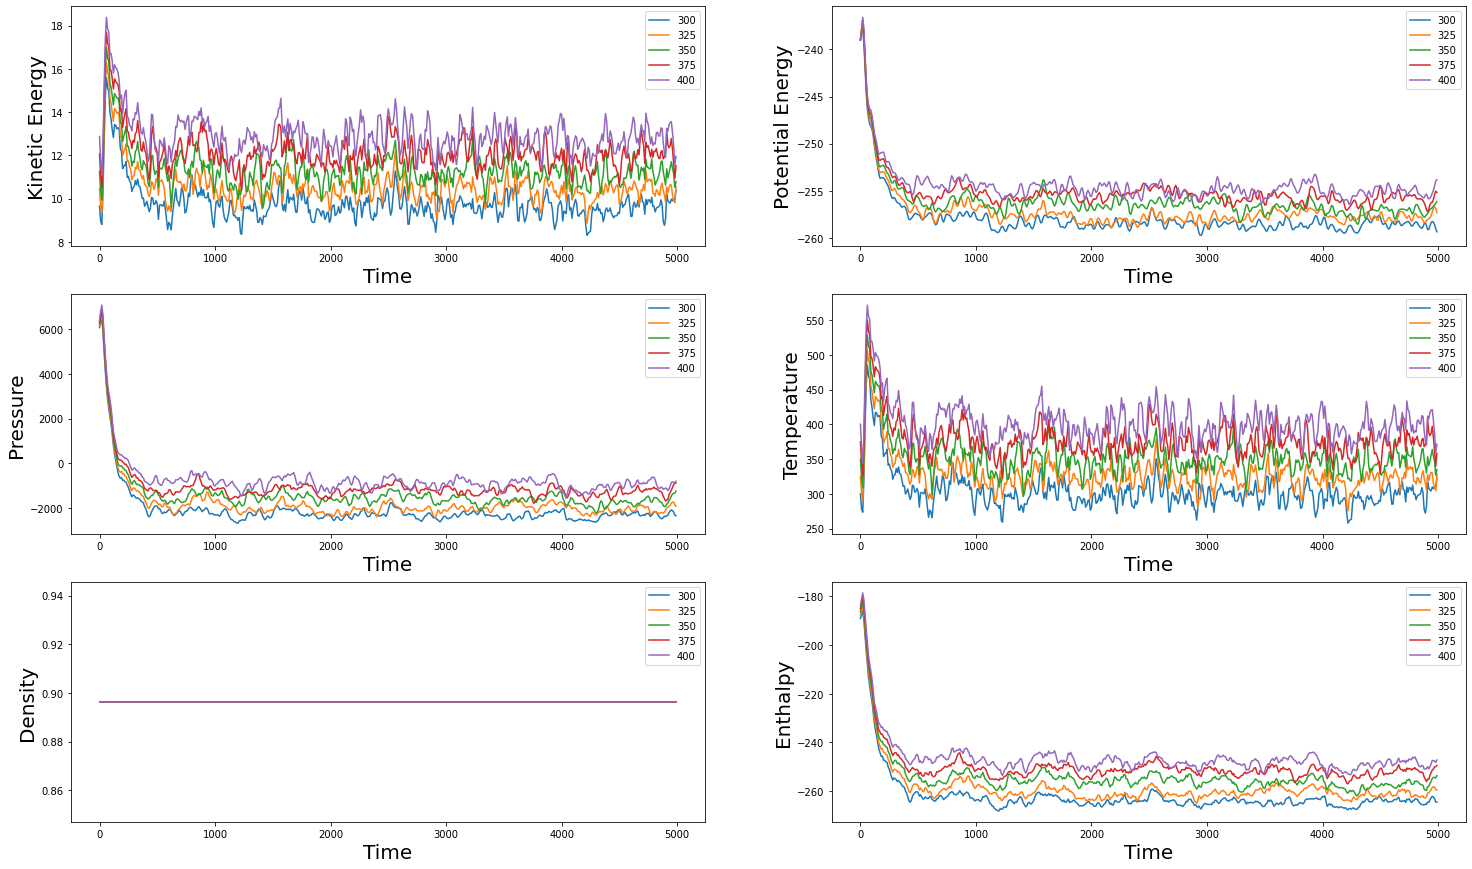

In [210]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:500]-energy[tmp].T[0][0]*0.005), energy[tmp].T[n+1][:500], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [198]:
%%bash
cat > "start_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/press/energy\${temperature}.dat


fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

EOF


In [199]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   10500    280.18577   -267.37386    9.0179964   -151.23421    0.9545838    9997.9195    -259.2996      250    21.542853    21.542853    21.542853            0            0            0   -304.55942    38.176321   -187.31954    167.51965    130.10014    305.52808 
   11000    305.24479   -267.47738    9.8245404    531.88687   0.96387426    9901.5529   -254.36574      250    21.473414    21.473414    21.473414            0            0            0    636.34494    521.45861    437.85705    294.33976    127.83868    129.89278 
   11500     298.6457    -267.3569    9.6121435    139.84716   0.96051833    9936.1476   -256.87747      250    21.498394    21.498394    21.498394            0            0            0    239.28802   -37.390332    217.64378    382.76228    48.939886    230.41792 
   12000    319.34719   -267.79711    10.278437    -392.3471   0.95130164    10032.414   -259.97544      250      21.5676      21.5676      21.5676            0            0            0   -192.65835   

---------------------------------------------------------------
Pair    | 8.9211     | 8.9211     | 8.9211     |   0.0 | 91.12
Bond    | 0.0013892  | 0.0013892  | 0.0013892  |   0.0 |  0.01
Neigh   | 0.45442    | 0.45442    | 0.45442    |   0.0 |  4.64
Comm    | 0.12166    | 0.12166    | 0.12166    |   0.0 |  1.24
Output  | 0.0020747  | 0.0020747  | 0.0020747  |   0.0 |  0.02
Modify  | 0.2573     | 0.2573     | 0.2573     |   0.0 |  2.63
Other   |            | 0.03221    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1924.00 ave        1924 max        1924 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        18787.0 ave       18787 max       18787 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18787
Ave neighs/atom = 75.148000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 565
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

To

    2500     348.0652   -259.08858    11.202749   -344.92322   0.92632508    10302.919   -250.10389      250    21.759726    21.759726    21.759726            0            0            0   -550.83528   -224.11377    -259.8206   -382.32997    62.160642    251.34054 
    3000    314.00969   -258.33744    10.106645   -912.75974   0.91324227    10450.515   -254.18445      250    21.863141    21.863141    21.863141            0            0            0   -1462.9763   -167.61905   -1107.6839    6.2693322   -175.85531   -2.2931984 
    3500    316.32118   -259.49314    10.181043   -641.38271   0.92520124    10315.434   -253.44157      250    21.768533    21.768533    21.768533            0            0            0   -799.89288   -561.75393   -562.50133   -159.09589    184.94135    329.81087 
    4000    332.07786   -259.50373    10.688184    701.13922   0.94357401    10114.577   -244.38924      250    21.626318    21.626318    21.626318            0            0            0    608.07907   

   18000    324.29654   -259.16802    10.437736    5.8555911   0.93111679    10249.898   -248.69283      250    21.722335    21.722335    21.722335            0            0            0   -304.83817    401.66178   -79.256835   -38.207061   -192.67899     123.2288 
   18500    307.92103   -258.91325    9.9106772   -90.325939   0.93026409    10259.293   -249.58096      250     21.72897     21.72897     21.72897            0            0            0    57.039766    384.76421   -712.78179    -97.17507    483.07711    307.16287 
   19000    309.15881    -258.5904    9.9505162    8.6796921   0.93125476    10248.379   -248.58436      250    21.721262    21.721262    21.721262            0            0            0    131.18255    364.32657   -469.47005   -207.17075    925.46289   -89.623018 
   19500    330.62737   -258.92867    10.641498   -22.217472   0.93054779    10256.165    -248.4294      250    21.726762    21.726762    21.726762            0            0            0    337.06617   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012521   | 0.012521   | 0.012521   |   0.0 | 78.04
Bond    | 2.32e-06   | 2.32e-06   | 2.32e-06   |   0.0 |  0.01
Neigh   | 0.0028778  | 0.0028778  | 0.0028778  |   0.0 | 17.94
Comm    | 0.00026709 | 0.00026709 | 0.00026709 |   0.0 |  1.66
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003759  |            |       |  2.34

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500     341.7423   -258.77512    10.999241   -48.255989   0.92758258    10288.951   -248.08577      250    21.749889    21.749889    21.749889            0            0            0   -139.38582    370.17758   -375.55973    228.53566   -219.91244   -651.42807 
   11000    326.48378   -257.44101    10.508134   -142.55592   0.92042514    10368.961   -247.85547      250    21.806121    21.806121    21.806121            0            0            0   -234.66275   -1073.2985    880.29351     230.0336   -137.91814   -314.79401 
   11500     341.4966   -257.83173    10.991333    -392.7934   0.92037446    10369.531   -249.38262      250    21.806521    21.806521    21.806521            0            0            0    -896.7452    113.68145   -395.31646   -369.15363   -274.48582   -420.82933 
   12000    363.40254    -258.7285    11.696393    143.69477   0.92806041    10283.654    -246.1098      250    21.746155    21.746155    21.746155            0            0            0     89.59926   

---------------------------------------------------------------
Pair    | 9.4849     | 9.4849     | 9.4849     |   0.0 | 90.76
Bond    | 0.0018303  | 0.0018303  | 0.0018303  |   0.0 |  0.02
Neigh   | 0.53494    | 0.53494    | 0.53494    |   0.0 |  5.12
Comm    | 0.11808    | 0.11808    | 0.11808    |   0.0 |  1.13
Output  | 0.0029904  | 0.0029904  | 0.0029904  |   0.0 |  0.03
Modify  | 0.27316    | 0.27316    | 0.27316    |   0.0 |  2.61
Other   |            | 0.03464    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1842.00 ave        1842 max        1842 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17828.0 ave       17828 max       17828 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17828
Ave neighs/atom = 71.312000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

To

    2500    410.14177   -256.92077    13.200731    1050.0465   0.93100925    10251.082   -237.00161      250    21.723172    21.723172    21.723172            0            0            0    103.21455    1343.2045    1703.7205    1180.9641   -250.49059   -14.697527 
    3000    360.02509   -256.64521    11.587687   -1144.9517   0.90232529    10576.953   -252.61605      250     21.95096     21.95096     21.95096            0            0            0   -1658.0506   -681.50472   -1095.2999   -27.782073    197.66253    43.076454 
    3500    363.73235   -256.75771    11.707008   -1244.0223   0.90122668    10589.846   -253.27327      250    21.959876    21.959876    21.959876            0            0            0   -1800.2462   -365.60067   -1566.2202   -282.30508   -130.62783    -720.4505 
    4000     387.6797   -256.97683    12.477772   -202.38906   0.91870944    10388.325   -245.81133      250    21.819686    21.819686    21.819686            0            0            0   -484.92628   

   18000    374.24766    -255.7305    12.045451   -125.31083   0.91403443    10441.458   -244.50171      250    21.856824    21.856824    21.856824            0            0            0   -567.67382    76.498037    115.24329    129.79179   -188.03243   -296.51015 
   18500    369.81251   -257.45155    11.902702    225.57908   0.92610819    10305.332    -244.0979      250    21.761425    21.761425    21.761425            0            0            0   -321.18205    669.65594    328.26336    45.385278   -44.419583    387.56371 
   19000    355.76117   -257.30609    11.450449    528.33224   0.93026181    10259.318   -242.47254      250    21.728988    21.728988    21.728988            0            0            0    42.434492    989.61656    552.94568   -177.68482   -428.73198    18.869107 
   19500    358.04106   -256.57901    11.523829    308.82979   0.92241204    10346.626    -243.0608      250    21.790452    21.790452    21.790452            0            0            0    1470.2097   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.021884   | 0.021884   | 0.021884   |   0.0 | 60.17
Bond    | 4.649e-06  | 4.649e-06  | 4.649e-06  |   0.0 |  0.01
Neigh   | 0.0092547  | 0.0092547  | 0.0092547  |   0.0 | 25.45
Comm    | 0.00028757 | 0.00028757 | 0.00028757 |   0.0 |  0.79
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.004937   |            |       | 13.58

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500    397.20314    -256.3404    12.784291    285.48351   0.92210275    10350.096   -241.71188      250    21.792888    21.792888    21.792888            0            0            0     26.16012    114.93218    715.35823    76.273563   -251.23642   -30.958013 
   11000     379.5576   -255.41374    12.216356    408.19137   0.91998324    10373.941   -240.55439      250    21.809611    21.809611    21.809611            0            0            0    -121.9376    70.700087    1275.8116    128.20997    151.57597   -385.77076 
   11500    399.83632   -255.34294    12.869042    14.875241   0.91108945    10475.209   -242.37664      250    21.880348    21.880348    21.880348            0            0            0   -298.86275   -9.0974238    352.58589    186.82476    -98.22251   -266.85511 
   12000    415.89965   -255.74711    13.386053   -573.84128   0.90345061    10563.778   -246.14462      250    21.941842    21.941842    21.941842            0            0            0   -867.00075   

---------------------------------------------------------------
Pair    | 8.741      | 8.741      | 8.741      |   0.0 | 91.41
Bond    | 0.0014857  | 0.0014857  | 0.0014857  |   0.0 |  0.02
Neigh   | 0.47934    | 0.47934    | 0.47934    |   0.0 |  5.01
Comm    | 0.10924    | 0.10924    | 0.10924    |   0.0 |  1.14
Output  | 0.0024701  | 0.0024701  | 0.0024701  |   0.0 |  0.03
Modify  | 0.19861    | 0.19861    | 0.19861    |   0.0 |  2.08
Other   |            | 0.03044    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1822.00 ave        1822 max        1822 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17669.0 ave       17669 max       17669 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17669
Ave neighs/atom = 70.676000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 669
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

To

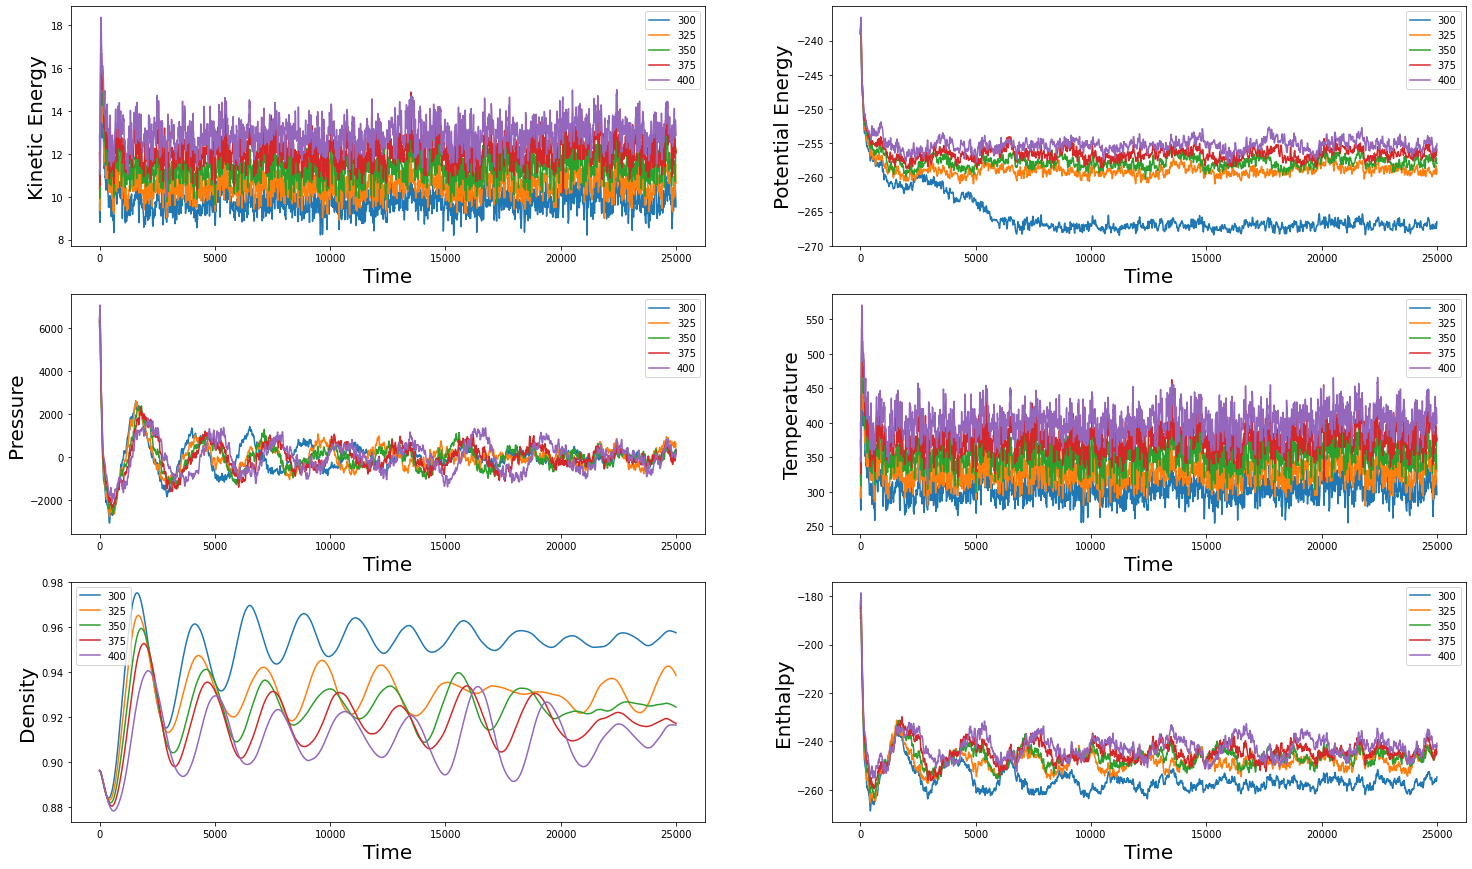

In [201]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:]-energy[tmp].T[0][0]*0.005), energy[tmp].T[n+1][:], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [202]:
%%bash
cat > "start_temp_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp_press/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

EOF

In [203]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   11000    294.63378   -258.66665    9.4830169   -2149.1045   0.89630466        10648   -263.46649      250           22           22           22            0            0            0   -1893.8218   -2059.6367   -2493.8549    89.634694    -22.84652   -253.43707 
   11500     296.5795    -258.6702    9.5456413   -2467.6002   0.89630466        10648   -265.52413      250           22           22           22            0            0            0   -2459.2532   -2691.1254   -2252.4219    61.688184    133.86173   -282.99233 
   12000    292.88457   -258.63418    9.4267173   -2170.1342   0.89630466        10648   -263.63009      250           22           22           22            0            0            0    -2452.073   -2406.2529   -1652.0766   -204.42904    421.98725   -142.93489 
   12500    309.90882   -259.22657    9.9746558   -2416.3305   0.89630466        10648   -265.31075      250           22           22           22            0            0            0   -3212.1571   

Neigh   | 0.46057    | 0.46057    | 0.46057    |   0.0 |  4.68
Comm    | 0.10763    | 0.10763    | 0.10763    |   0.0 |  1.09
Output  | 0.0013052  | 0.0013052  | 0.0013052  |   0.0 |  0.01
Modify  | 0.10636    | 0.10636    | 0.10636    |   0.0 |  1.08
Other   |            | 0.03931    |            |       |  0.40

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1796.00 ave        1796 max        1796 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17333.0 ave       17333 max       17333 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17333
Ave neighs/atom = 69.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 574
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${pressureDamp}
fix             1 all nph iso 1 1 10
fix             2

   37000     307.6976   -260.65725    9.9034861   -158.11568    0.9360299    10196.097      -251.76      250    21.684263    21.684263    21.684263            0            0            0    -101.7056   -136.74901   -235.89242    239.63688   -163.69219   -228.13781 
   37500    293.16582   -260.01368    9.4357693   -203.67541    0.9342226    10215.822   -251.87659      250    21.698237    21.698237    21.698237            0            0            0   -15.892686   -440.22107   -154.91248   -280.10428   -81.741069   -110.41498 
   38000    310.49063   -260.60194    9.9933818    23.461446    0.9385759    10168.439   -250.45966      250    21.664638    21.664638    21.664638            0            0            0    443.22154    31.845995    -404.6832    129.19705    198.72632    217.48336 
   38500    326.09473   -260.16769    10.495612    551.96219   0.94221234    10129.194    -246.1825      250    21.636731    21.636731    21.636731            0            0            0    342.70717   

Total # of neighbors = 17910
Ave neighs/atom = 71.640000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 564
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:20
LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 325
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region       

    3000    340.20042   -258.74669    10.949614   -2119.2262   0.89630466        10648   -261.88137      250           22           22           22            0            0            0   -1780.1706   -2710.1514   -1867.3565   -91.174981    71.494738    59.057581 
    3500    314.55712   -257.83066    10.124265   -1977.1533   0.89630466        10648   -260.84648      250           22           22           22            0            0            0   -1807.2443    -1863.257   -2260.9586    402.41775    442.84746    -41.78951 
    4000    326.75853   -257.03353    10.516977   -1744.5624   0.89630466        10648   -258.11084      250           22           22           22            0            0            0   -2173.2679   -1002.0276   -2058.3916    66.721556    -560.3854    33.524617 
    4500    296.41352   -257.30623    9.5402993    -2081.524   0.89630466        10648   -261.59965      250           22           22           22            0            0            0   -1605.2055   

   18500    306.98815    -258.4077    9.8806518   -2168.1313   0.89630466        10648   -262.93636      250           22           22           22            0            0            0   -1475.4139   -2430.6143   -2598.3657   -249.75349   -313.76685    102.56902 
   19000    301.85816   -257.63268    9.7155391   -1856.9051   0.89630466        10648   -260.25806      250           22           22           22            0            0            0   -2548.7082   -1181.9029   -1840.1043   -533.29328    343.33343   -110.47251 
   19500    342.16593   -258.62969    11.012876   -2113.3805   0.89630466        10648   -261.66226      250           22           22           22            0            0            0   -2647.3887   -1590.3358   -2102.4168    216.92438    57.188046   -37.283904 
   20000    339.84105   -257.32013    10.938048   -1854.3638   0.89630466        10648   -258.70611      250           22           22           22            0            0            0   -1797.1117   

   29000    337.90127   -259.87899    10.875615    569.74423   0.94458026    10103.802    -245.4104      250    21.618635    21.618635    21.618635            0            0            0    77.188761    1108.9845    523.05945    75.690481   -57.761212    292.88101 
   29500     309.8409   -259.60686    9.9724697   -58.510038   0.93223892     10237.56   -250.00826      250    21.713616    21.713616    21.713616            0            0            0   -64.254504    151.38996   -262.66557    444.83556   -79.797763    348.49533 
   30000     306.5142    -259.1456    9.8653975   -555.21168   0.92340968    10335.447   -252.86181      250    21.782602    21.782602    21.782602            0            0            0    -215.1968   -353.27036   -1097.1679   -63.113865    151.85344   -505.55163 
   30500    363.30125   -258.76391    11.693133    -109.9709   0.92492369    10318.529   -247.77902      250     21.77071     21.77071     21.77071            0            0            0   -843.52457   

   44500    310.98149   -258.57762    10.009181    687.00295    0.9418787    10132.782   -244.22357      250    21.639285    21.639285    21.639285            0            0            0    486.14676    234.08535    1340.7767    44.497285   -633.46408    665.64751 
   45000    329.92552   -258.67362    10.618909   -100.80279   0.92921162    10270.913   -248.70092      250    21.737171    21.737171    21.737171            0            0            0   -43.278225    211.79864   -470.92879    133.78898   -614.37734    177.45276 
   45500    344.56082   -259.08293    11.089957    -714.8168   0.91995955    10374.208   -252.62146      250    21.809799    21.809799    21.809799            0            0            0   -635.45831   -657.55933   -851.43275    143.78572   -75.185436   -73.023253 
   46000    311.94303   -258.09196    10.040128   -511.51365   0.92246561    10346.025   -251.35492      250     21.79003     21.79003     21.79003            0            0            0   -1094.1185   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012186   | 0.012186   | 0.012186   |   0.0 | 77.42
Bond    | 2.62e-06   | 2.62e-06   | 2.62e-06   |   0.0 |  0.02
Neigh   | 0.0028872  | 0.0028872  | 0.0028872  |   0.0 | 18.34
Comm    | 0.00026813 | 0.00026813 | 0.00026813 |   0.0 |  1.70
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003953  |            |       |  2.51

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    341.64449   -257.14955    10.996093    -1785.243   0.89630466        10648   -258.01811      250           22           22           22            0            0            0   -2031.3281   -1499.7557   -1824.6451    33.099295   -176.52788   -72.389616 
   11500    341.22994   -256.97028    10.982751   -1802.0583   0.89630466        10648   -257.96394      250           22           22           22            0            0            0   -1462.4652   -1983.8504   -1959.8592   -430.00704   -395.85703    265.98786 
   12000    368.95384   -257.27669    11.875066   -1874.1059   0.89630466        10648   -257.85686      250           22           22           22            0            0            0   -2381.5707   -1934.0786   -1306.6682    78.484461   -763.62664    114.22875 
   12500    374.45826   -257.35628     12.05223   -1877.0677   0.89630466        10648   -257.77896      250           22           22           22            0            0            0   -2192.4365   

Neigh   | 0.484      | 0.484      | 0.484      |   0.0 |  4.50
Comm    | 0.1352     | 0.1352     | 0.1352     |   0.0 |  1.26
Output  | 0.0033934  | 0.0033934  | 0.0033934  |   0.0 |  0.03
Modify  | 0.16942    | 0.16942    | 0.16942    |   0.0 |  1.58
Other   |            | 0.03321    |            |       |  0.31

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1828.00 ave        1828 max        1828 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17296.0 ave       17296 max       17296 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17296
Ave neighs/atom = 69.184000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${pressureDamp}
fix             1 all nph iso 1 1 10
fix             2

   37000    373.71878   -258.94124    12.028429    737.52061   0.93545024    10202.415   -242.21639      250    21.688741    21.688741    21.688741            0            0            0    1043.1803    1089.5279    79.853639    190.86353   -55.429913    3.6688273 
   37500    367.36163    -258.7759    11.823819    458.39199   0.93446677    10213.153   -244.03004      250    21.696347    21.696347    21.696347            0            0            0   -8.2738554     593.9643    789.48553    266.58529    766.97105     238.7411 
   38000    352.07645   -257.15842    11.331854    96.549513   0.92369562    10332.248   -245.20393      250    21.780354    21.780354    21.780354            0            0            0    219.65656    1011.8452    -941.8532    399.38349    355.92001    403.54642 
   38500    399.57394   -256.66384    12.860597   -215.91871   0.91435578    10437.788    -245.2099      250    21.854263    21.854263    21.854263            0            0            0   -691.76974   

Total # of neighbors = 17833
Ave neighs/atom = 71.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 617
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:19
LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 375
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region       

    3000    368.24746   -255.31626     11.85233    -1025.084   0.89630466        10648   -250.27659      250           22           22           22            0            0            0   -1142.9481   -854.76671   -1077.5374    -148.6593   -184.62421   -32.314111 
    3500    377.80282   -256.51288    12.159877    -1324.645   0.89630466        10648   -253.15654      250           22           22           22            0            0            0   -1724.0732   -917.45102   -1332.4107    119.03595    321.18571   -309.30557 
    4000    379.60007   -255.58456    12.217723   -1068.0278   0.89630466        10648    -250.4649      250           22           22           22            0            0            0   -1623.4279   -738.14439   -842.51104   -49.924453     129.3865   -919.66193 
    4500    322.85435   -254.48759    10.391318   -1049.3511   0.89630466        10648   -251.07022      250           22           22           22            0            0            0   -1186.8149   

   18500    372.63512   -256.36788    11.993551    -1458.328   0.89630466        10648   -254.06632      250           22           22           22            0            0            0   -689.13073   -1593.1363    -2092.717   -243.22362    417.53038     458.7246 
   19000    364.61886   -256.37531    11.735541    -1478.065   0.89630466        10648   -254.46293      250           22           22           22            0            0            0   -1865.0417   -808.70677   -1760.4464    -550.1888    185.28009   -294.70226 
   19500    371.84214   -255.76256    11.968028    -1399.171   0.89630466        10648   -253.09336      250           22           22           22            0            0            0   -1873.7288   -1293.5953   -1030.1888    341.77825   -10.083358   -620.41243 
   20000     378.8265   -254.45967    12.192825   -942.75783   0.89630466        10648   -248.53237      250           22           22           22            0            0            0   -1046.4554   

   29000    375.41776   -257.14467    12.083112    620.03654   0.93075796    10253.849   -241.09335      250    21.725126    21.725126    21.725126            0            0            0    580.65574   -111.57823    1391.0321    107.36575   -114.17724  -0.80096551 
   29500    342.98772   -257.12156    11.039326    744.93478   0.93358911    10222.754   -241.32915      250    21.703143    21.703143    21.703143            0            0            0    365.95479    803.19172    1065.6578   -16.034551   -689.59626   -225.67451 
   30000    347.43606   -257.08587    11.182499    166.12925    0.9238514    10330.505    -244.8322      250     21.77913     21.77913     21.77913            0            0            0    551.92127    403.75665   -457.29015   -46.102933    233.68614   -92.929702 
   30500    408.31425   -255.73576    13.141911   -27.978512   0.91048383    10482.176    -242.7769      250    21.885198    21.885198    21.885198            0            0            0   -438.05635   

   44500    388.10005   -257.63307    12.491301    3.0840441   0.92263037    10344.177   -245.12185      250    21.788733    21.788733    21.788733            0            0            0   -277.95606    339.95065   -52.742457    411.01735    143.02224   -542.83138 
   45000    396.03846   -255.91124    12.746805   -454.12662   0.90888337    10500.634   -246.14078      250    21.898037    21.898037    21.898037            0            0            0   -614.87083   -1171.4189    423.90987    271.52037    185.49402    17.142175 
   45500    392.58154   -255.34919    12.635541   -785.23788   0.90124025    10589.687   -247.90372      250    21.959766    21.959766    21.959766            0            0            0   -156.56318   -823.20652   -1375.9439    66.227003   -163.65289   -315.56794 
   46000    361.44712   -254.38311    11.633456   -399.51425   0.90540856    10540.934   -245.37811      250    21.926015    21.926015    21.926015            0            0            0   -230.70396   

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.029762   | 0.029762   | 0.029762   |   0.0 | 81.64
Bond    | 4.933e-06  | 4.933e-06  | 4.933e-06  |   0.0 |  0.01
Neigh   | 0.0031774  | 0.0031774  | 0.0031774  |   0.0 |  8.72
Comm    | 0.00032769 | 0.00032769 | 0.00032769 |   0.0 |  0.90
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.003183   |            |       |  8.73

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    377.90182   -254.08274    12.163063   -766.98163   0.89630466        10648     -247.017      250           22           22           22            0            0            0   -576.79672   -992.47147   -731.67671   -414.16202    -888.3542   -203.09928 
   11500    385.78137   -254.52472    12.416673   -611.86319   0.89630466        10648   -246.17446      250           22           22           22            0            0            0    -519.6378    -479.3571   -836.59468    139.02114    110.47626    95.634813 
   12000    414.73111   -255.22444    13.348443   -1023.2675   0.89630466        10648   -248.67659      250           22           22           22            0            0            0   -199.10951   -1517.9192   -1352.7738    118.69283    30.471517    614.86176 
   12500    393.08783   -254.69041    12.651837    -1011.131   0.89630466        10648    -248.7585      250           22           22           22            0            0            0   -1084.0564   

Neigh   | 0.4946     | 0.4946     | 0.4946     |   0.0 |  5.41
Comm    | 0.127      | 0.127      | 0.127      |   0.0 |  1.39
Output  | 0.0011914  | 0.0011914  | 0.0011914  |   0.0 |  0.01
Modify  | 0.10699    | 0.10699    | 0.10699    |   0.0 |  1.17
Other   |            | 0.03138    |            |       |  0.34

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1810.00 ave        1810 max        1810 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17307.0 ave       17307 max       17307 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17307
Ave neighs/atom = 69.228000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 668
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${pressureDamp}
fix             1 all nph iso 1 1 10
fix             2

   37000    423.21996   -255.50982    13.621663   -733.69467   0.90140673    10587.731   -246.73666      250    21.958414    21.958414    21.958414            0            0            0   -1208.5349   -25.975081   -966.57405   -252.36418    38.669468    -251.4003 
   37500    385.62402   -254.40916    12.411608   -221.37683   0.90627688    10530.835   -243.45262      250     21.91901     21.91901     21.91901            0            0            0   -512.98464    19.522733    -170.6686   -405.18489   -249.30559   -130.33329 
   38000    396.22588   -255.18985    12.752838    96.541722   0.91632843    10415.318   -241.80942      250    21.838569    21.838569    21.838569            0            0            0    266.11768    368.52302   -345.01553    20.928054    771.93447    128.68684 
   38500    442.85641   -253.57106    14.253677    1318.9095   0.92152625    10356.571   -230.79187      250    21.797432    21.797432    21.797432            0            0            0    1486.1035   

Total # of neighbors = 17685
Ave neighs/atom = 70.740000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 676
Dangerous builds = 0

unfix           1
unfix           2

# neigh_modify every 1 delay 5 check yes

Total wall time: 0:00:18


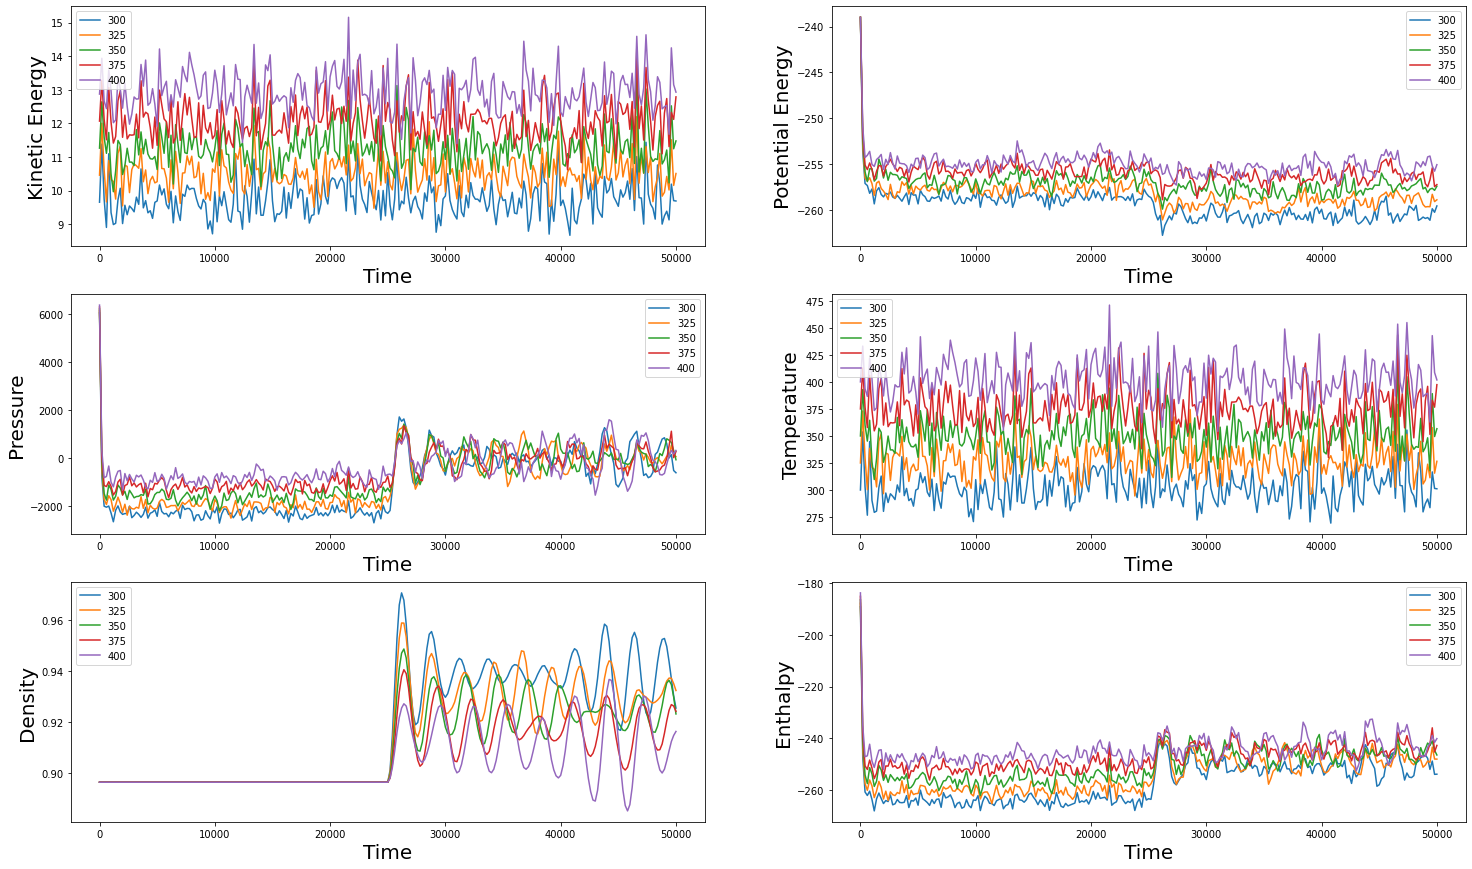

In [207]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp_press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][::20]-energy[tmp].T[0][0]*0.005), energy[tmp].T[n+1][::20], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [10]:
%%bash
# create PLUMED input file
cat > "start.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart.\${p_id}
include in.setup

# NPT

timer           timeout 23:50:00 every 5000
reset_timestep  0
include         in.dump

fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run             500000 # 1 ns

EOF

In [11]:
%%bash
lmp -in start.lmp

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal 350.
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart.${p_id}
read_restart restart.0
Reading restart file ...
  restart file = 30 Jul 2021, LAMMPS = 30 Jul 2021
  restoring atom style full from restart
  triclinic box = (0.14275131 0.14275131 0.14275131) to (21.857249 21.857249 21.857249) with tilt (0.0000000 0.0000000 0.0000000)
  1 by 1 by 1 MPI processor grid
  pair style eam/fs stores no restart info
  250 atoms
Finding 1-2 1-3 1-4 neighbors ...
  special

CalledProcessError: Command 'b'lmp -in start.lmp\n'' returned non-zero exit status 1.